In [1]:
import os
import netCDF4
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.image import imread
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.animation import FuncAnimation
import datetime
from matplotlib import colors

from scipy import stats

In [2]:
year_ini = 1957
year_end = 2022

In [3]:
#years = np.array2string(np.arange(year_ini, year_end+1))
years_download = np.arange(year_ini, year_end+2).astype(str).tolist()
years = np.arange(year_ini, year_end+1).astype(str).tolist()

In [4]:
#####################
##  DOWNLOAD DATA  ##
#####################

print('Model Data')
## Download selected month
import cdsapi
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['2m_temperature'],
        'year': years_download,
        'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
        'time': '00:00',
        'area': [-40, -180, -90, 180],
        'format': 'netcdf',
    },
    'ERA5_t2m_Ant.nc')

Model Data


2023-08-17 10:57:17,842 INFO Welcome to the CDS
2023-08-17 10:57:17,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-08-17 10:57:17,948 INFO Request is completed
2023-08-17 10:57:17,949 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data9/adaptor.mars.internal-1692200770.802838-25300-8-1f6a5c0b-42d2-41c9-b784-ad56f0674393.nc to ERA5_t2m_Ant.nc (882.2M)
2023-08-17 10:58:15,676 INFO Download rate 15.3M/s                                                                     


Result(content_length=925061176,content_type=application/x-netcdf,location=https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data9/adaptor.mars.internal-1692200770.802838-25300-8-1f6a5c0b-42d2-41c9-b784-ad56f0674393.nc)

In [5]:
#################
# Load ERA5 data
#################
#Path
filename = 'ERA5_t2m_Ant.nc'

#Load netcdf
ncdf = netCDF4.Dataset(filename)

#Get dimensions
lons = ncdf.variables['longitude'][:]
lats = ncdf.variables['latitude'][:]
times = ncdf.variables['time'][:]

#Calculate datetime
dtimes = np.empty(len(times), dtype='datetime64[h]')
for i,t in enumerate(times):
    dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(int(t),'h')
dtimes = dtimes.astype('datetime64')

#Get variables
t2m = ncdf.variables['t2m']
if np.size(np.shape(t2m)) == 4: #Check dimensions
    t2m = ncdf.variables['t2m'][:,0,:,:]-273.15
else:
    t2m = ncdf.variables['t2m'][:,:,:]-273.15

In [6]:
#Check if we have Jan and Feb of the next year
if np.all(np.array([x.year for x in dtimes.tolist()][-2:]) == np.int(years_download[-1])) == True:
    print("You can continue")
else:
    print("STOP script: you don't have yet January and February of the following year")

You can continue


C:\Users\gonzalez\AppData\Local\Temp\ipykernel_29204\2796099268.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.all(np.array([x.year for x in dtimes.tolist()][-2:]) == np.int(years_download[-1])) == True:


In [7]:
#################
# Calculate timeseries
#################
#Calculate ZIL by longitude for every month
ix_end = np.where(dtimes == np.datetime64(years_download[-1] + '-02-01T00'))[0][0]+1
lat0 = np.empty((np.size(dtimes[:ix_end]),np.size(lons)))

for j,dtime in enumerate(dtimes[:ix_end]):
    print(dtime)
    #print(j)
    for i,lon in enumerate(lons):
        ixs = [np.where(t2m[j,:,i] > 0)[0][-1],np.where(t2m[j,:,i] > 0)[0][-1]+1]
        #print(ixs)
        lats_ixs = lats[ixs]
        T_ixs = [t2m[j,ixs[0],i], t2m[j,ixs[1],i]]
        lat0[j,i] = np.interp(0, np.flipud(T_ixs), np.flipud(lats_ixs))
        
#Calculate ZIL by longitude for every season
lat0_ANN = np.empty((np.size(years),np.size(lons)))
lat0_MAM = np.empty((np.size(years),np.size(lons)))
lat0_JJA = np.empty((np.size(years),np.size(lons)))
lat0_SON = np.empty((np.size(years),np.size(lons)))
lat0_DJF = np.empty((np.size(years),np.size(lons)))
for i,year in enumerate(years):
    print(year)
    ix = i*12
    lat0_ANN[i] = np.mean(lat0[ix:ix+12,:], axis=0)
    lat0_MAM[i] = np.mean(lat0[ix+2:ix+2+3,:], axis=0)
    lat0_JJA[i] = np.mean(lat0[ix+5:ix+5+3,:], axis=0)
    lat0_SON[i] = np.mean(lat0[ix+8:ix+8+3,:], axis=0)
    lat0_DJF[i] = np.mean(lat0[ix+11:ix+11+3,:], axis=0)
    
#### Create timeseries ###
#for Antarctica
lat0_ANN_Ant_timeseries = np.mean(lat0_ANN[:,:],1)
lat0_MAM_Ant_timeseries = np.mean(lat0_MAM[:,:],1)
lat0_JJA_Ant_timeseries = np.mean(lat0_JJA[:,:],1)
lat0_SON_Ant_timeseries = np.mean(lat0_SON[:,:],1)
lat0_DJF_Ant_timeseries = np.mean(lat0_DJF[:,:],1)
#for the Antarctic Peninsula
lat0_ANN_AP_timeseries = np.mean(lat0_ANN[:,380:560],1)
lat0_MAM_AP_timeseries = np.mean(lat0_MAM[:,380:560],1)
lat0_JJA_AP_timeseries = np.mean(lat0_JJA[:,380:560],1)
lat0_SON_AP_timeseries = np.mean(lat0_SON[:,380:560],1)
lat0_DJF_AP_timeseries = np.mean(lat0_DJF[:,380:560],1)

1957-01-01T00
1957-02-01T00
1957-03-01T00
1957-04-01T00
1957-05-01T00
1957-06-01T00
1957-07-01T00
1957-08-01T00
1957-09-01T00
1957-10-01T00
1957-11-01T00
1957-12-01T00
1958-01-01T00
1958-02-01T00
1958-03-01T00
1958-04-01T00
1958-05-01T00
1958-06-01T00
1958-07-01T00
1958-08-01T00
1958-09-01T00
1958-10-01T00
1958-11-01T00
1958-12-01T00
1959-01-01T00
1959-02-01T00
1959-03-01T00
1959-04-01T00
1959-05-01T00
1959-06-01T00
1959-07-01T00
1959-08-01T00
1959-09-01T00
1959-10-01T00
1959-11-01T00
1959-12-01T00
1960-01-01T00
1960-02-01T00
1960-03-01T00
1960-04-01T00
1960-05-01T00
1960-06-01T00
1960-07-01T00
1960-08-01T00
1960-09-01T00
1960-10-01T00
1960-11-01T00
1960-12-01T00
1961-01-01T00
1961-02-01T00
1961-03-01T00
1961-04-01T00
1961-05-01T00
1961-06-01T00
1961-07-01T00
1961-08-01T00
1961-09-01T00
1961-10-01T00
1961-11-01T00
1961-12-01T00
1962-01-01T00
1962-02-01T00
1962-03-01T00
1962-04-01T00
1962-05-01T00
1962-06-01T00
1962-07-01T00
1962-08-01T00
1962-09-01T00
1962-10-01T00
1962-11-01T00
1962-1

2005-12-01T00
2006-01-01T00
2006-02-01T00
2006-03-01T00
2006-04-01T00
2006-05-01T00
2006-06-01T00
2006-07-01T00
2006-08-01T00
2006-09-01T00
2006-10-01T00
2006-11-01T00
2006-12-01T00
2007-01-01T00
2007-02-01T00
2007-03-01T00
2007-04-01T00
2007-05-01T00
2007-06-01T00
2007-07-01T00
2007-08-01T00
2007-09-01T00
2007-10-01T00
2007-11-01T00
2007-12-01T00
2008-01-01T00
2008-02-01T00
2008-03-01T00
2008-04-01T00
2008-05-01T00
2008-06-01T00
2008-07-01T00
2008-08-01T00
2008-09-01T00
2008-10-01T00
2008-11-01T00
2008-12-01T00
2009-01-01T00
2009-02-01T00
2009-03-01T00
2009-04-01T00
2009-05-01T00
2009-06-01T00
2009-07-01T00
2009-08-01T00
2009-09-01T00
2009-10-01T00
2009-11-01T00
2009-12-01T00
2010-01-01T00
2010-02-01T00
2010-03-01T00
2010-04-01T00
2010-05-01T00
2010-06-01T00
2010-07-01T00
2010-08-01T00
2010-09-01T00
2010-10-01T00
2010-11-01T00
2010-12-01T00
2011-01-01T00
2011-02-01T00
2011-03-01T00
2011-04-01T00
2011-05-01T00
2011-06-01T00
2011-07-01T00
2011-08-01T00
2011-09-01T00
2011-10-01T00
2011-1

In [8]:
#################
# Save files in netcdf
#################
years = np.array(years).astype(int)


### All Antarctica ###
##ANN
#Create dataframe and save data
f = netCDF4.Dataset('t_srs\ZIL\AntClimNow_ZIL_Ant_ANN_timeseries.nc','w', format='NETCDF4')    
f.createDimension('times', None)
time = f.createVariable('years', 'i4', 'times')
ZIL = f.createVariable('ZIL', 'f4', ('times'))
time[:] = years
ZIL[:] = lat0_ANN_Ant_timeseries
#Add global attributes
f.description = "Mean annual ZIL position in Antarctica in ANN"
time.units = 'years'
ZIL.units = 'degrees north'
f.close()

##DJF
#Create dataframe and save data
f = netCDF4.Dataset('t_srs\ZIL\AntClimNow_ZIL_Ant_DJF_timeseries.nc','w', format='NETCDF4')    
f.createDimension('times', None)
time = f.createVariable('years', 'i4', 'times')
ZIL = f.createVariable('ZIL', 'f4', ('times'))
time[:] = years
ZIL[:] = lat0_DJF_Ant_timeseries
#Add global attributes
f.description = "Mean annual ZIL position in Antarctica in DJF"
time.units = 'years'
ZIL.units = 'degrees north'
f.close()

##MAM
#Create dataframe and save data
f = netCDF4.Dataset('t_srs\ZIL\AntClimNow_ZIL_Ant_MAM_timeseries.nc','w', format='NETCDF4')    
f.createDimension('times', None)
time = f.createVariable('years', 'i4', 'times')
ZIL = f.createVariable('ZIL', 'f4', ('times'))
time[:] = years
ZIL[:] = lat0_MAM_Ant_timeseries
#Add global attributes
f.description = "Mean annual ZIL position in Antarctica in MAM"
time.units = 'years'
ZIL.units = 'degrees north'
f.close()

##JJA
#Create dataframe and save data
f = netCDF4.Dataset('t_srs\ZIL\AntClimNow_ZIL_Ant_JJA_timeseries.nc','w', format='NETCDF4')    
f.createDimension('times', None)
time = f.createVariable('years', 'i4', 'times')
ZIL = f.createVariable('ZIL', 'f4', ('times'))
time[:] = years
ZIL[:] = lat0_JJA_Ant_timeseries
#Add global attributes
f.description = "Mean annual ZIL position in Antarctica in JJA"
time.units = 'years'
ZIL.units = 'degrees north'
f.close()

##SON
#Create dataframe and save data
f = netCDF4.Dataset('t_srs\ZIL\AntClimNow_ZIL_Ant_SON_timeseries.nc','w', format='NETCDF4')    
f.createDimension('times', None)
time = f.createVariable('years', 'i4', 'times')
ZIL = f.createVariable('ZIL', 'f4', ('times'))
time[:] = years
ZIL[:] = lat0_SON_Ant_timeseries
#Add global attributes
f.description = "Mean annual ZIL position in Antarctica in SON"
time.units = 'years'
ZIL.units = 'degrees north'
f.close()



### Antarctic Peninsula ###
##ANN
#Create dataframe and save data
f = netCDF4.Dataset('t_srs\ZIL\AntClimNow_ZIL_AP_ANN_timeseries.nc','w', format='NETCDF4')    
f.createDimension('times', None)
time = f.createVariable('years', 'i4', 'times')
ZIL = f.createVariable('ZIL', 'f4', ('times'))
time[:] = years
ZIL[:] = lat0_ANN_AP_timeseries
#Add global attributes
f.description = "Mean annual ZIL position in Antarctic Peninsula in ANN"
time.units = 'years'
ZIL.units = 'degrees north'
f.close()

##DJF
#Create dataframe and save data
f = netCDF4.Dataset('t_srs\ZIL\AntClimNow_ZIL_AP_DJF_timeseries.nc','w', format='NETCDF4')    
f.createDimension('times', None)
time = f.createVariable('years', 'i4', 'times')
ZIL = f.createVariable('ZIL', 'f4', ('times'))
time[:] = years
ZIL[:] = lat0_DJF_AP_timeseries
#Add global attributes
f.description = "Mean annual ZIL position in Antarctic Peninsula in DJF"
time.units = 'years'
ZIL.units = 'degrees north'
f.close()

##MAM
#Create dataframe and save data
f = netCDF4.Dataset('t_srs\ZIL\AntClimNow_ZIL_AP_MAM_timeseries.nc','w', format='NETCDF4')    
f.createDimension('times', None)
time = f.createVariable('years', 'i4', 'times')
ZIL = f.createVariable('ZIL', 'f4', ('times'))
time[:] = years
ZIL[:] = lat0_MAM_AP_timeseries
#Add global attributes
f.description = "Mean annual ZIL position in Antarctic Peninsula in MAM"
time.units = 'years'
ZIL.units = 'degrees north'
f.close()

##JJA
#Create dataframe and save data
f = netCDF4.Dataset('t_srs\ZIL\AntClimNow_ZIL_AP_JJA_timeseries.nc','w', format='NETCDF4')    
f.createDimension('times', None)
time = f.createVariable('years', 'i4', 'times')
ZIL = f.createVariable('ZIL', 'f4', ('times'))
time[:] = years
ZIL[:] = lat0_JJA_AP_timeseries
#Add global attributes
f.description = "Mean annual ZIL position in Antarctic Peninsula in JJA"
time.units = 'years'
ZIL.units = 'degrees north'
f.close()

##SON
#Create dataframe and save data
f = netCDF4.Dataset('t_srs\ZIL\AntClimNow_ZIL_AP_SON_timeseries.nc','w', format='NETCDF4')    
f.createDimension('times', None)
time = f.createVariable('years', 'i4', 'times')
ZIL = f.createVariable('ZIL', 'f4', ('times'))
time[:] = years
ZIL[:] = lat0_SON_AP_timeseries
#Add global attributes
f.description = "Mean annual ZIL position in Antarctic Peninsula in SON"
time.units = 'years'
ZIL.units = 'degrees north'
f.close()

AntClimNow_ZIL_Ant ANN


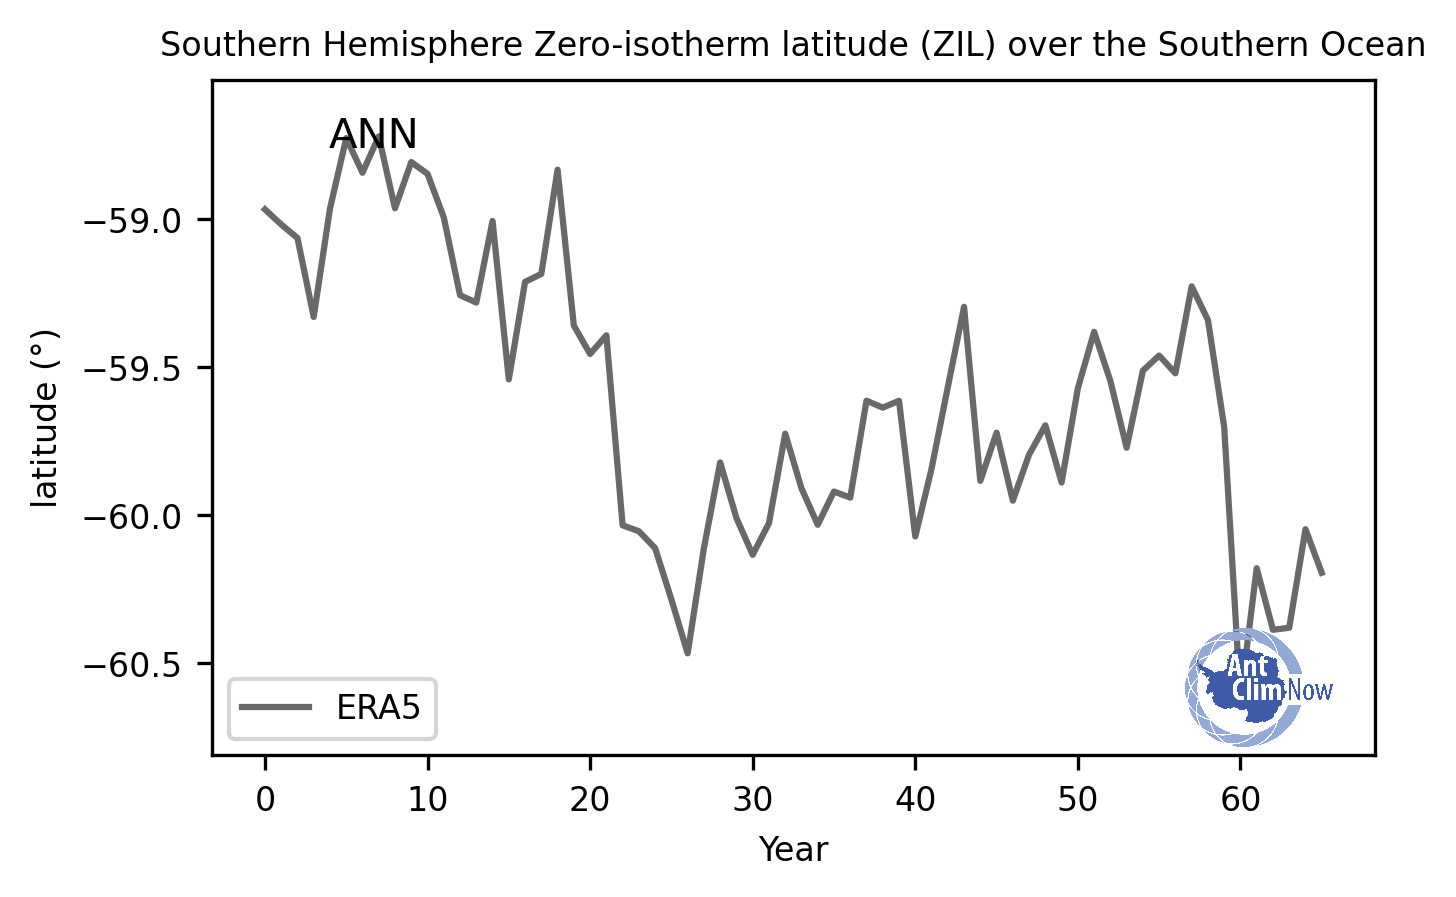

AntClimNow_ZIL_Ant MAM


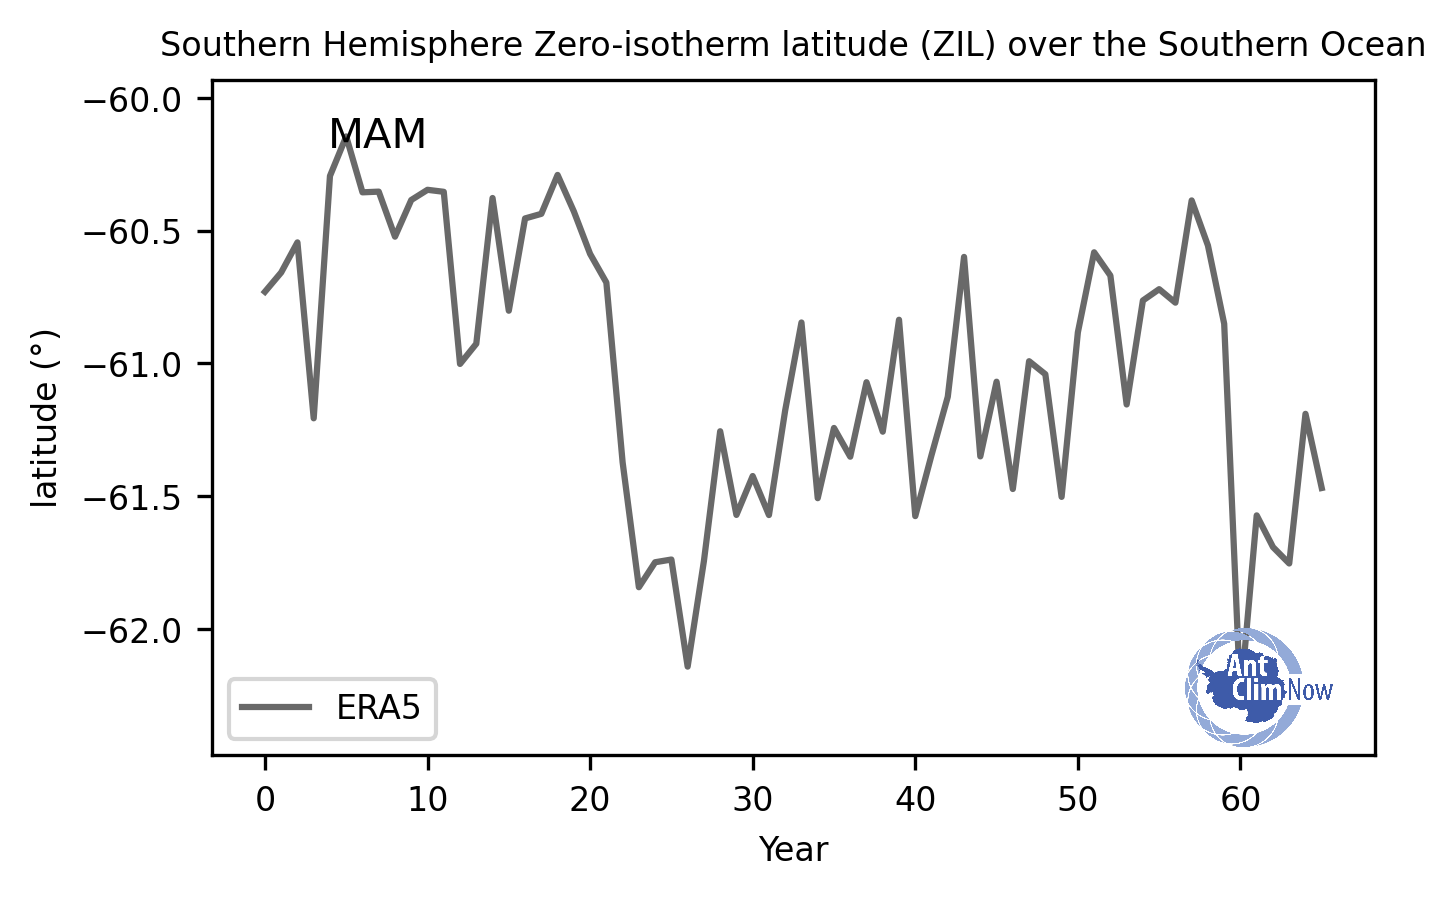

AntClimNow_ZIL_Ant JJA


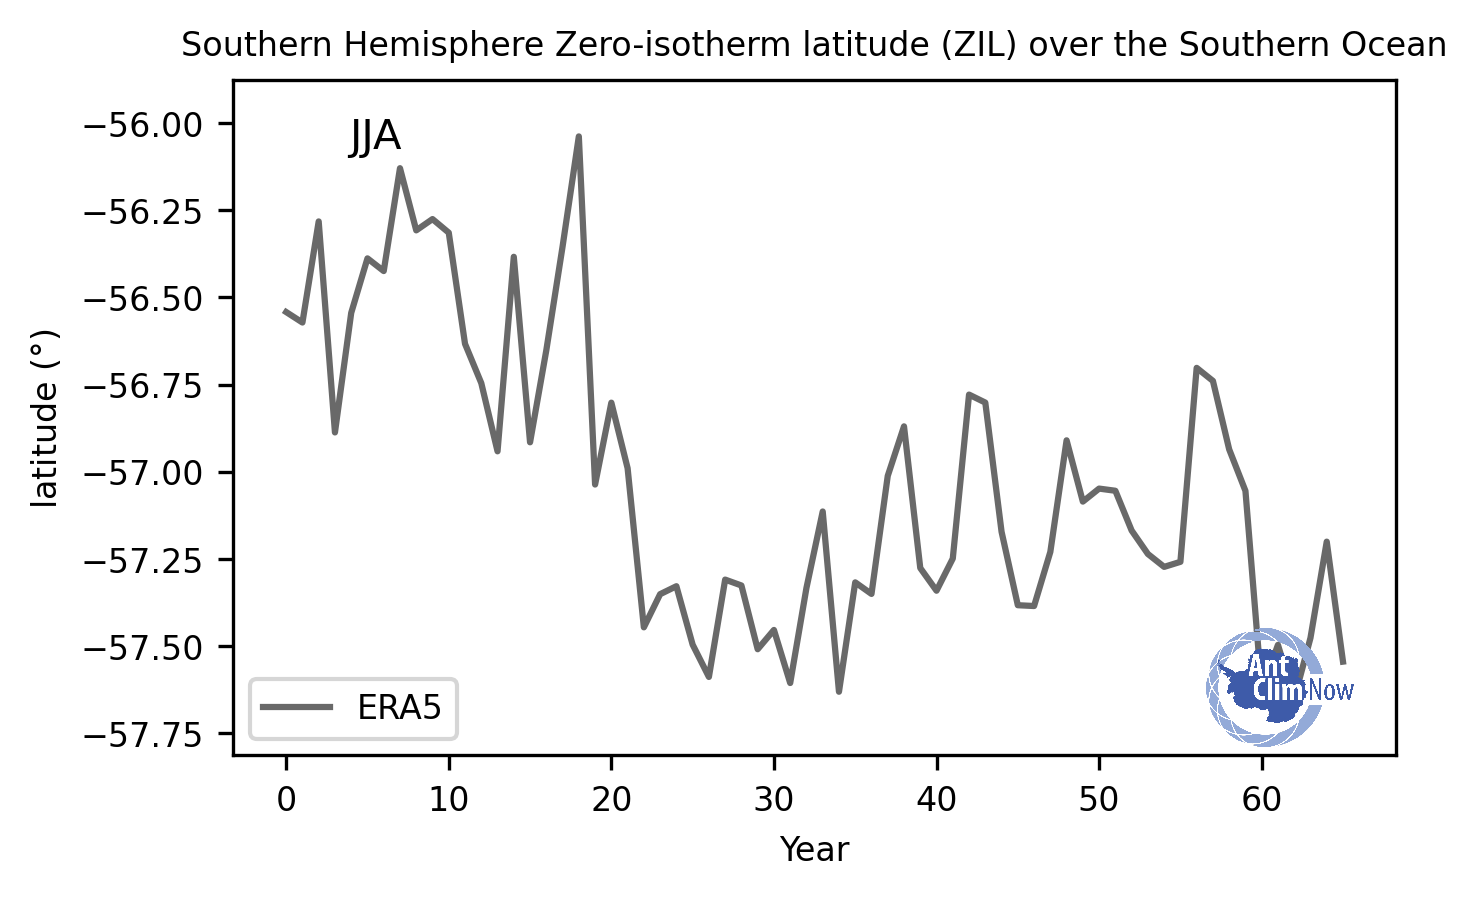

AntClimNow_ZIL_Ant SON


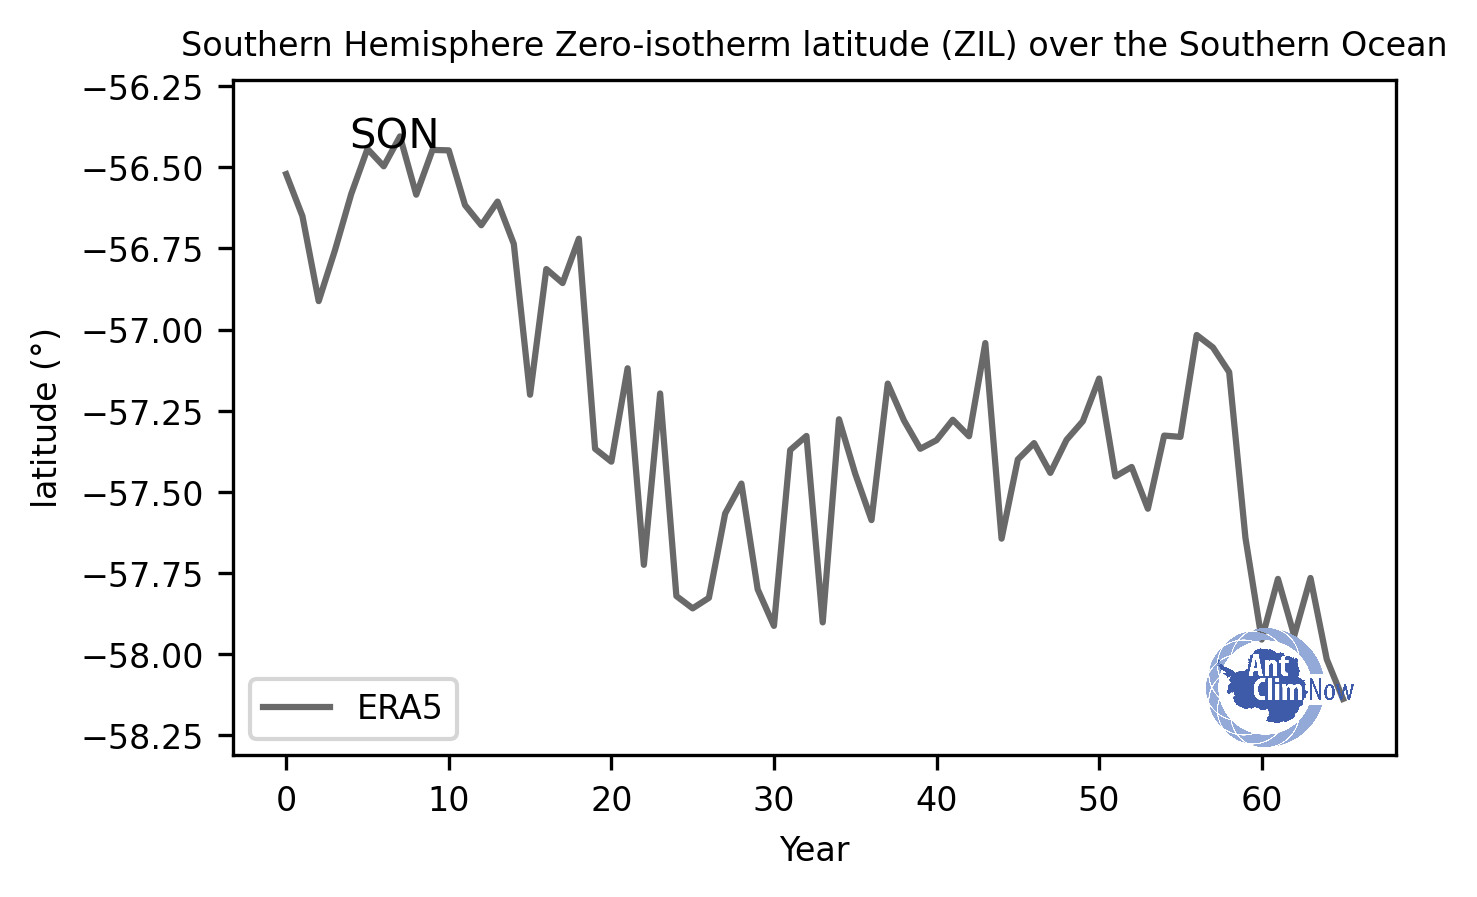

AntClimNow_ZIL_Ant DJF


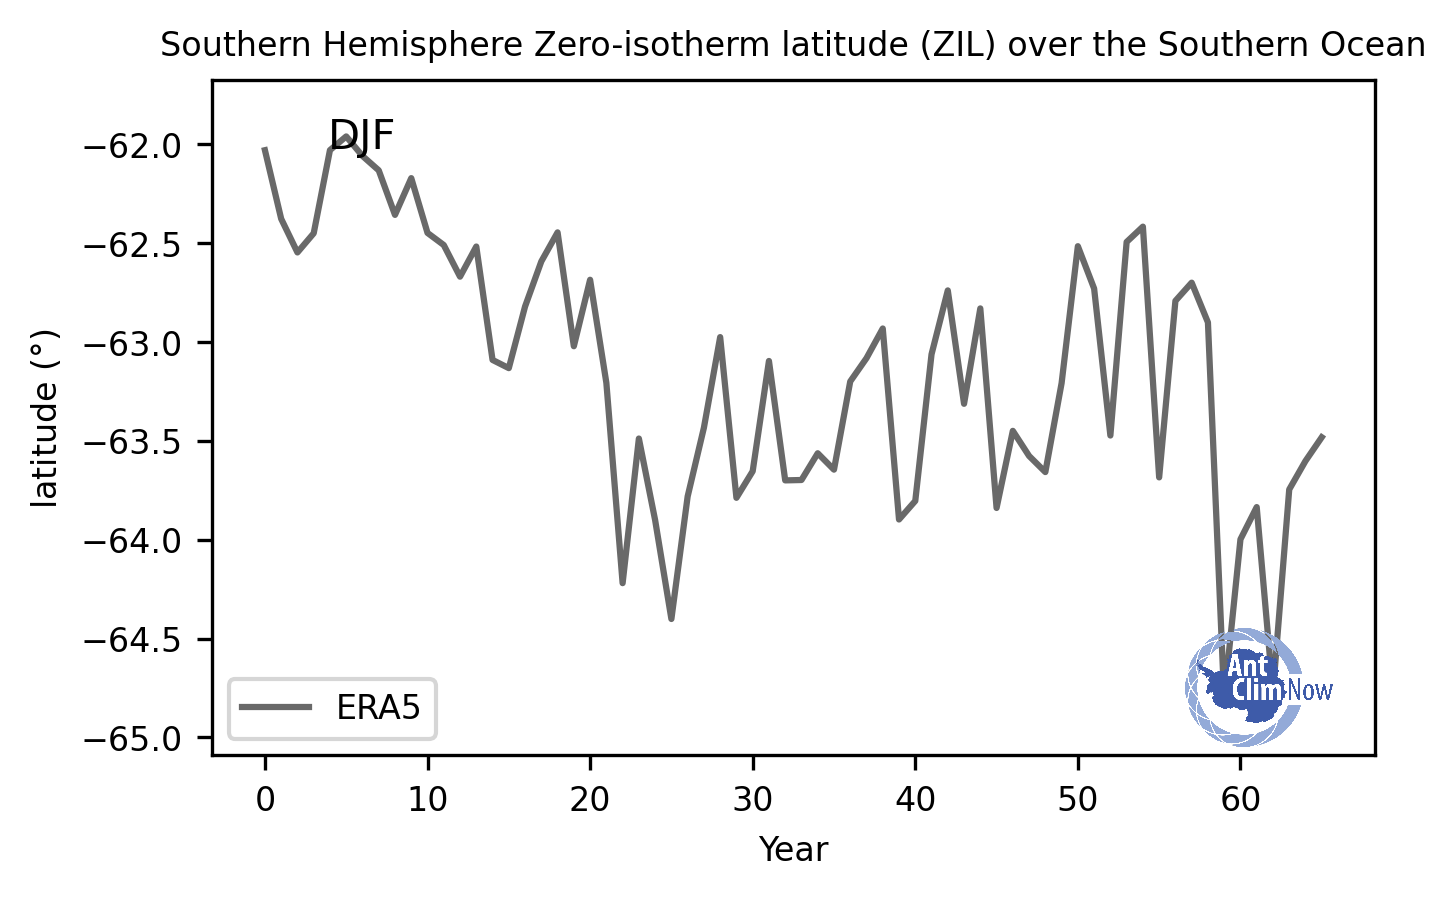

AntClimNow_ZIL_AP ANN


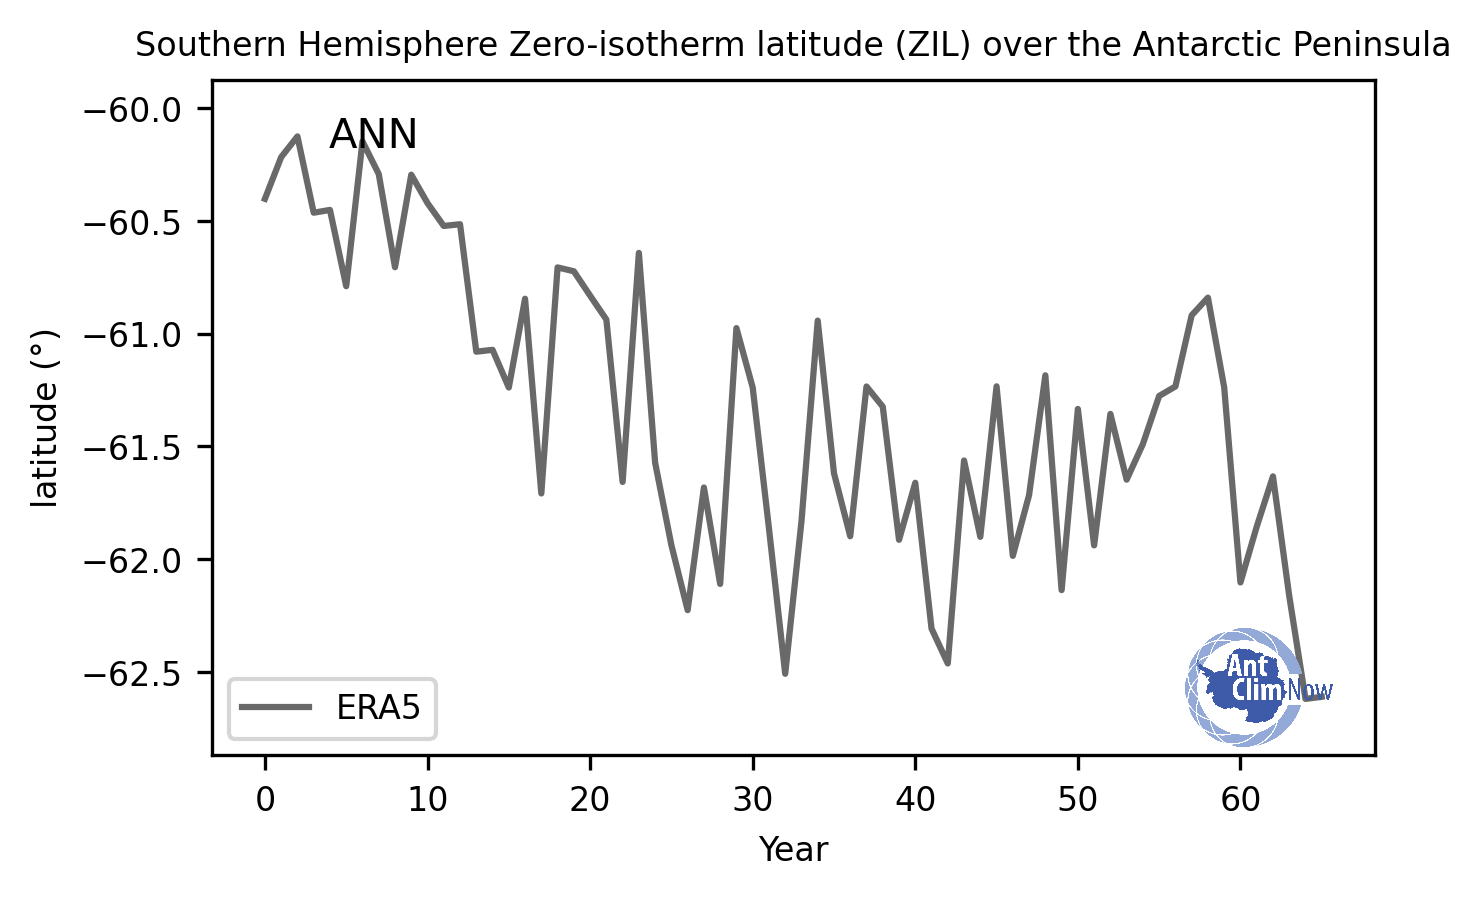

AntClimNow_ZIL_AP MAM


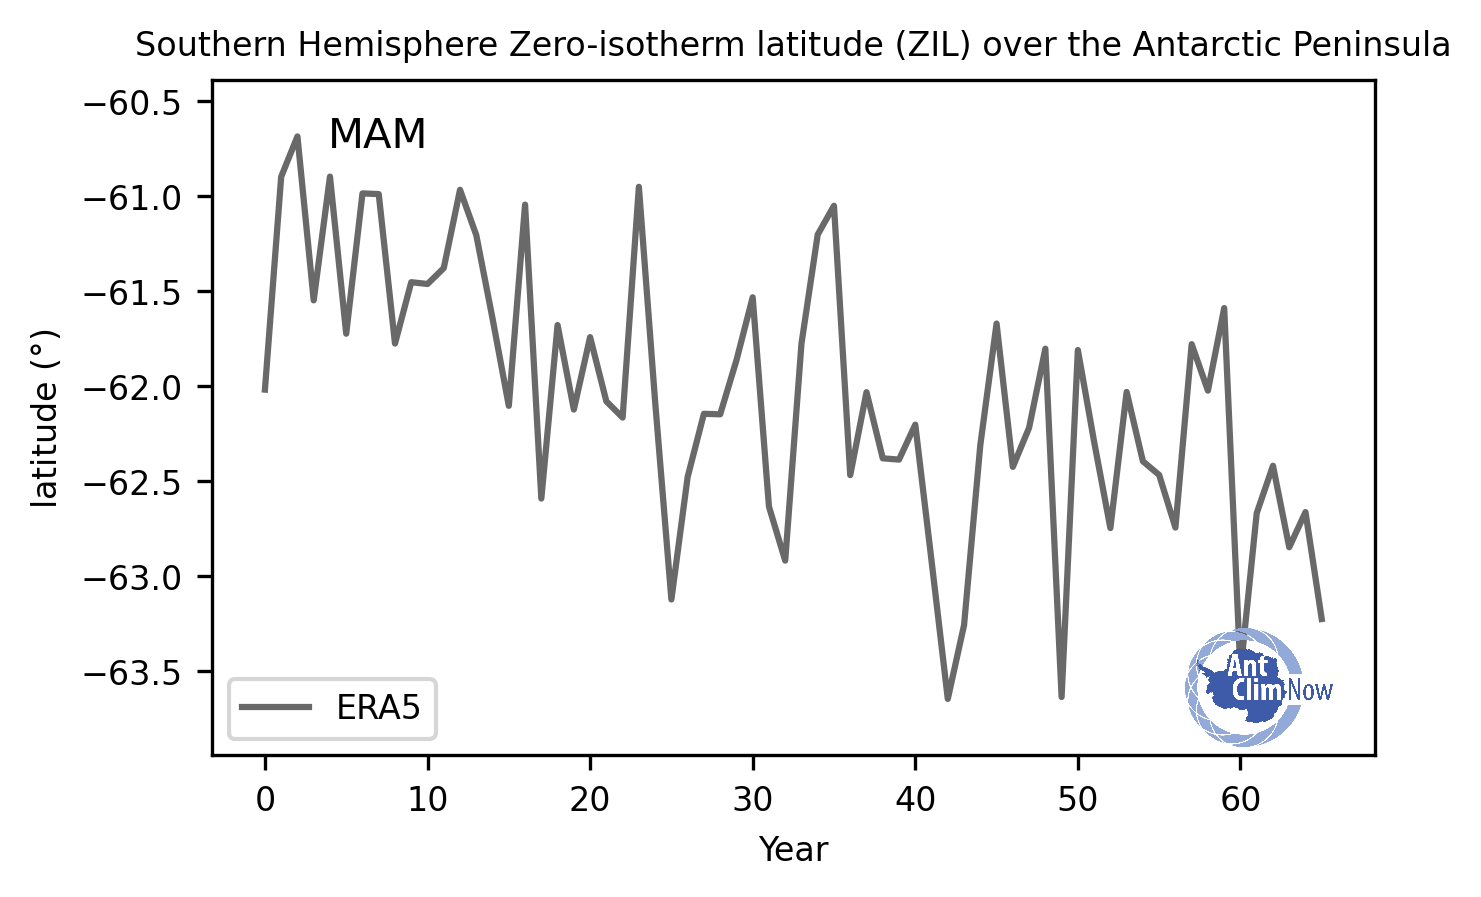

AntClimNow_ZIL_AP JJA


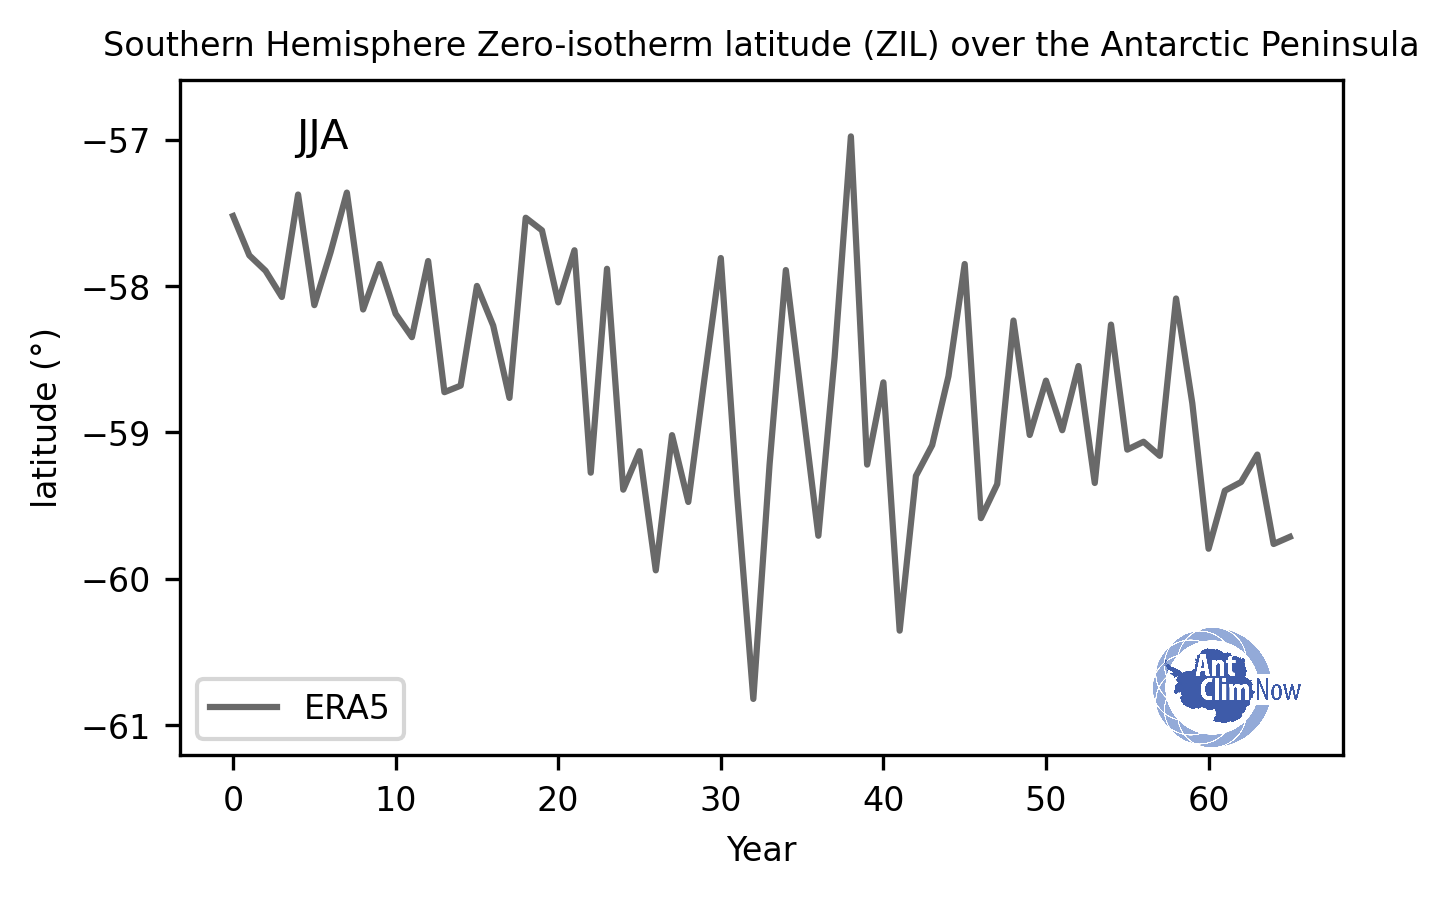

AntClimNow_ZIL_AP SON


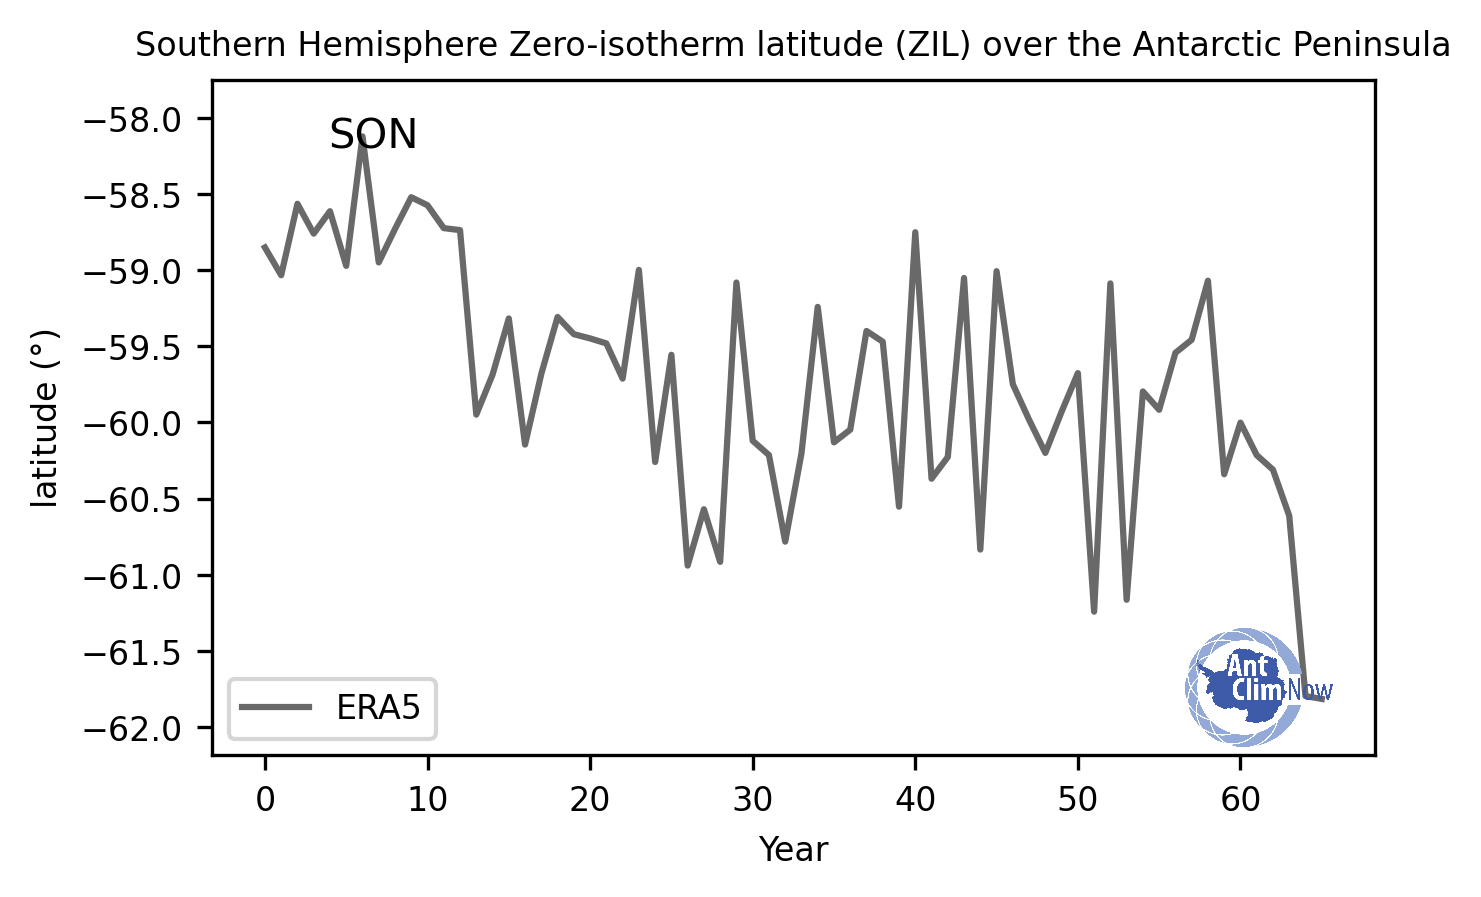

AntClimNow_ZIL_AP DJF


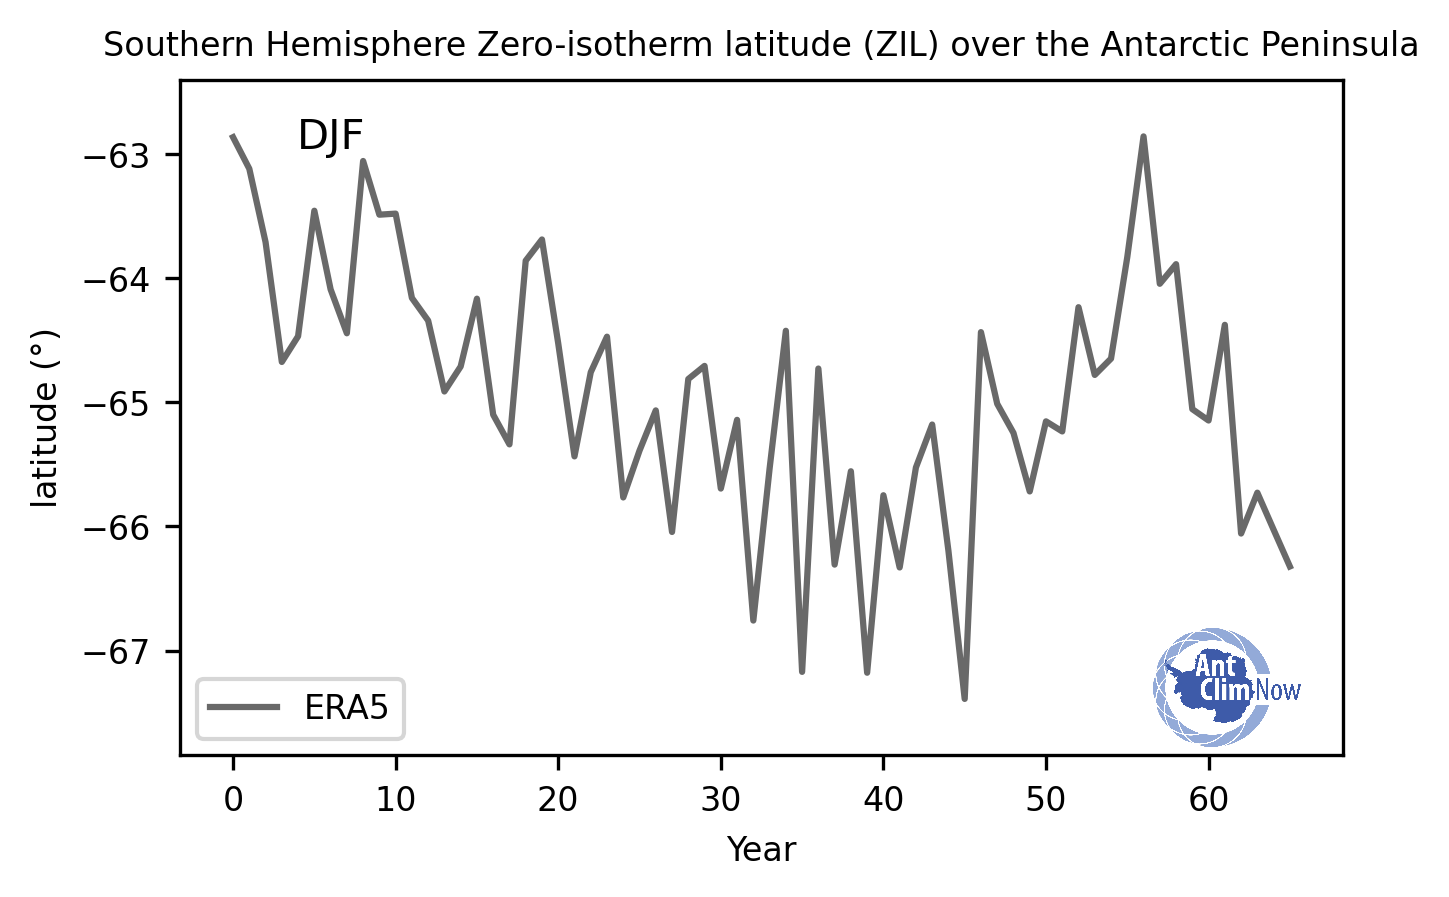

In [9]:
import iris  # Written for Iris version 2.4.0. 
import iris.plot as iplt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import iris.coord_categorisation
import os, sys
from netCDF4 import Dataset  
import datetime as dt
from netCDF4 import date2num,num2date

### Plot time series of AntClimNow Antarctic Climate Indicators (ACIs)
### Input: Two arguments, indicator name (e.g. SAM_marshall) and season ('djf', 'mam', 'jja' or 'son'). 
### 
### Files required: 
### 1. AntClimNow logo (AntClimNow_logo_15cm_300dpi.png)
### 2. Input data files for each ACI. 
###
### Example: run aci_monthly_plot_v2_0.py 'SAM_marshall' 'djf'
###
### Author: Tom Bracegirdle (tjbra@bas.ac.uk)
### Date: 31 May 2023
### Modified by: Sergi González-Herrero (sergi.gonzalez@slf.ch)
###
### Notes: Requires data files to be in a directory 't_srs'. The code is written to handle 
### the differing formats of the different datasets. 
###       

### --------- Definitions ------------

def yrange_calc(cube):
  d_max = np.max(cube.data)
  d_min = np.min(cube.data)
  ylim_buffer = .1*(d_max-d_min)
  y_range = [d_min - ylim_buffer, d_max+ylim_buffer]
  return y_range

### Arguments (diagnostics name, season months)
diag_names = ['AntClimNow_ZIL_Ant', 'AntClimNow_ZIL_AP']
seasons = ['ANN', 'MAM', 'JJA', 'SON', 'DJF']

for diag_name in diag_names:
    for season in seasons:
        print(diag_name + ' ' + season)
        #Start Tom Bracegirdle modified script
        if diag_name == 'AntClimNow_ZIL_Ant': 
          vn='timeseries'
          fname = diag_name+'_'+season+'_'+vn+'.nc'
          diag_plt = iris.load_cube('t_srs/ZIL/'+fname, 'ZIL')
          p_title = 'Southern Hemisphere Zero-isotherm latitude (ZIL) over the Southern Ocean'
          source_lab = 'ERA5'
          ylab_units = 'latitude ($\degree$)'  

        if diag_name == 'AntClimNow_ZIL_AP': 
          vn='timeseries'
          fname = diag_name+'_'+season+'_'+vn+'.nc'
          diag_plt = iris.load_cube('t_srs/ZIL/'+fname, 'ZIL')
          p_title = 'Southern Hemisphere Zero-isotherm latitude (ZIL) over the Antarctic Peninsula'
          source_lab = 'ERA5'
          ylab_units = 'latitude ($\degree$)'  

        ### ----- Create time series plot -----
        ylim_diag = yrange_calc(diag_plt)

        plt.figure(figsize=(5, 3), dpi=300)
        plt.gcf().subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.925)
        ax = plt.subplot()
        line1, = iplt.plot(diag_plt, color='dimgrey', label = source_lab)

        xy = (.9, .1) # Annotation position (in axis fraction coordinates). 
        ax.plot(xy[0], xy[1])
        #ax.plot(jsi_sh_djf.data)
        # Annotate the 1st position with a text box ('Test 1')
        arr_img = plt.imread("AntClimNow_logo_15cm_300dpi.png")
        imagebox = OffsetImage(arr_img, zoom=0.02)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, xy, xycoords='axes fraction', frameon=False)
        ax.add_artist(ab)
        ax.set_ylim(ylim_diag)
        ax.set_xlabel('Year', size=8)
        ax.set_ylabel(ylab_units, size=8)
        ax.set_title(p_title, size=8)
        ax.text(.1,.9, season, transform=ax.transAxes)
        ax.xaxis.set_tick_params(labelsize=8)
        ax.yaxis.set_tick_params(labelsize=8)
        ax.legend(handles=[line1], fontsize=8, loc='lower left')

        plt.show() 
        plt.savefig('t_srs/ZIL/'+fname+'_'+season+'.png')
        plt.close()
